## Description

Produce a plot showing what fraction of the genome is covered at different depths.

In [1]:
import phase3_data

In [2]:
v3 = phase3_data.release_data()

In [3]:
import numba
import numpy as np
import dask.array as da

In [4]:
import allel
import pandas as pd

In [5]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask

In [6]:
dask_me = "kubernetes"

In [7]:
if dask_me == "kubernetes":
    # kubernetes cluster setup

    n_workers = 5
    cluster = KubeCluster()
    cluster.scale_up(n_workers)
    #cluster.adapt(minimum=1, maximum=n_workers)
    cluster

    # dask client setup

    client = Client(cluster)
    
    
elif dask_me == "single":
    dask.config.set(scheduler='threads')
    client = None
else:
    client = Client()
    
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.34.51.2:42907
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-e49e26d2-c527-11ea-835e-36d701234168
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.34.51.2:42907 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
sample_sets = v3.all_samplesets

In [9]:
all_meta = v3.load_metadata_by_sampleset(sample_sets)

distributed.scheduler - INFO - Register tcp://10.34.56.3:35069
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.56.3:35069
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.53.3:43137
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.53.3:43137
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.52.3:40433
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.52.3:40433
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.54.3:33419
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.54.3:33419
distributed.core - INFO - Starting established connection
/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

In [10]:
chromosomes = "2L", "2R", "3L", "3R", "X"

In [11]:
males_select = all_meta.sex_call == "M"

select = (all_meta.species_gambcolu_arabiensis == "gamb_colu") & males_select

In [12]:
gt = v3.load_calldata_by_sampleset("X", sample_sets, field="GT")
gt = allel.GenotypeDaskArray(gt)
gt

<GenotypeDaskArray shape=(23385349, 3483, 2) dtype=int8>

In [13]:
gt_sel = gt.compress(select.values, axis=1)
gt_sel

<GenotypeDaskArray shape=(23385349, 220, 2) dtype=int8>

In [14]:
gt_sel.shape

(23385349, 220, 2)

In [15]:
pd.crosstab(all_meta.sampleset, all_meta.sex_call)

sex_call,F,M,UKN
sampleset,,,
AG1000G-AO,77,4,0
AG1000G-BF-A,151,30,0
AG1000G-BF-B,74,28,0
AG1000G-BF-C,13,0,0
AG1000G-CD,44,32,0
AG1000G-CF,73,0,0
AG1000G-CI,80,0,0
AG1000G-CM-A,258,45,0
AG1000G-CM-B,97,0,0


In [16]:
gt.shape

(23385349, 3483, 2)

In [17]:
select.shape

(3483,)

In [18]:
het = gt_sel.is_het()
het

,Array,Chunk
Bytes,5.14 GB,7.50 MB
Shape,"(23385349, 220)","(300000, 25)"
Count,16096 Tasks,1638 Chunks
Type,bool,numpy.ndarray


In [19]:
het[:10].compute()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
gt[:10].compute()

<GenotypeArray shape=(10, 3483, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [21]:
gamb_colu_mask = v3.load_mask("X", "gamb_colu")
gamb_colu_mask

dask.array<from-zarr, shape=(23385349,), dtype=bool, chunksize=(300000,), chunktype=numpy.ndarray>

In [22]:
het_filtered = da.compress(gamb_colu_mask, het, axis=0)

In [23]:
is_called = gt_sel.is_called()

In [24]:
is_called[:10].compute()

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [25]:
is_called_sum_all = is_called.sum(axis=0).compute()

In [26]:
is_called_sum_filtered = da.compress(gamb_colu_mask, is_called, axis=0).sum(axis=0).compute()

In [27]:
het_sum_all = het.sum(axis=0).compute()
het_sum_filtered = het_filtered.sum(axis=0).compute()

In [28]:
pre_filtering_mer = het_sum_all / is_called_sum_all
post_filtering_mer = het_sum_filtered / is_called_sum_filtered

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

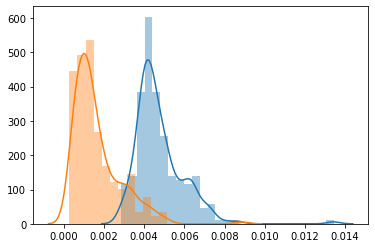

In [30]:
sns.distplot(pre_filtering_mer, label="pre")
sns.distplot(post_filtering_mer, label="post")

In [31]:
pre_des = pd.Series(pre_filtering_mer).describe()
pre_des

count    220.000000
mean       0.004762
std        0.001222
min        0.002851
25%        0.004019
50%        0.004441
75%        0.005222
max        0.013418
dtype: float64

In [32]:
post_des = pd.Series(post_filtering_mer).describe()
post_des

count    220.000000
mean       0.001651
std        0.001178
min        0.000277
25%        0.000783
50%        0.001272
75%        0.002068
max        0.008824
dtype: float64

In [33]:
## Make table
out_df = pd.concat([pre_des, post_des], axis=1, keys=["pre-filtering", "post-filtering"])

# drop std because non-normal
out_df = out_df.T.drop(["std"], axis=1)

In [34]:
out_df["fraction_accessible"] = (1.0, gamb_colu_mask.mean().compute())

In [35]:
out_df.to_csv("../content/tables/mer_X.csv", float_format="%.5f")

In [36]:
fold = np.log2(post_filtering_mer) - np.log2(pre_filtering_mer)
pd.Series(fold).describe()

count    220.000000
mean      -1.805228
std        0.683291
min       -3.661070
25%       -2.203439
50%       -1.742307
75%       -1.286910
max       -0.604595
dtype: float64

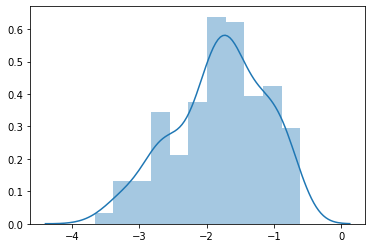

In [37]:
sns.distplot(fold)

In [38]:
out_df

,count,mean,min,25%,50%,75%,max,fraction_accessible
pre-filtering,220.0,0.004762,0.002851,0.004019,0.004441,0.005222,0.013418,1.000000
post-filtering,220.0,0.001651,0.000277,0.000783,0.001272,0.002068,0.008824,0.699703
